# Generate Results


In [16]:
import os
import sys
import json
from collections import defaultdict
import pandas as pd
import numpy as np

root_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(root_path)

ROOT_DIR = r"C:\Projects\Research\SWEEP\SWEEP"

def read_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def extract_metrics(data):
    metrics = data.get('metrics', {})
    match_type_dist = metrics.get('match_type_distribution', {})
    
    # Flatten match_type_distribution
    for match_type, values in match_type_dist.items():
        metrics[f'match_type_{match_type}_count'] = values[0]
        metrics[f'match_type_{match_type}_percentage'] = values[1]
    
    return metrics

def process_directory(base_path):
    results = defaultdict(lambda: defaultdict(dict))
    
    for sector in os.listdir(base_path):
        sector_path = os.path.join(base_path, sector)
        if os.path.isdir(sector_path):
            for activity in os.listdir(sector_path):
                activity_path = os.path.join(sector_path, activity)
                if os.path.isdir(activity_path):
                    for file in os.listdir(activity_path):
                        if file.endswith('_response.json'):
                            file_path = os.path.join(activity_path, file)
                            model = file.split('_response.json')[0]
                            data = read_json_file(file_path)
                            metrics = extract_metrics(data)
                            results[sector][activity][model] = metrics
    
    return results

def calculate_model_averages(results):
    model_averages = defaultdict(lambda: defaultdict(float))
    model_counts = defaultdict(int)
    
    for sector in results:
        for activity in results[sector]:
            for model, metrics in results[sector][activity].items():
                for metric, value in metrics.items():
                    if isinstance(value, (int, float)):
                        model_averages[model][metric] += value
                        model_counts[model] += 1
    
    for model in model_averages:
        for metric in model_averages[model]:
            model_averages[model][metric] /= model_counts[model]
    
    return dict(model_averages)

def generate_reports(results, model_averages):
    # Activity comparison report
    activity_report = []
    for sector in results:
        for activity in results[sector]:
            for model, metrics in results[sector][activity].items():
                report_entry = {
                    'Sector': sector,
                    'Activity': activity,
                    'Model': model
                }
                for metric, value in metrics.items():
                    if isinstance(value, (int, float)):
                        report_entry[metric] = value
                activity_report.append(report_entry)
    
    activity_df = pd.DataFrame(activity_report)
    
    # Add match type distribution columns
    match_types = [col.split('_')[2] for col in activity_df.columns if col.startswith('match_type_') and col.endswith('_percentage')]
    for match_type in match_types:
        activity_df[f'Match Type {match_type}'] = activity_df[f'match_type_{match_type}_percentage']
    
    activity_df.to_csv('activity_comparison_report.csv', index=False)
    
    # Overall model comparison report
    model_df = pd.DataFrame(model_averages).T
    model_df.to_csv('overall_model_comparison_report.csv')
    
    return activity_df, model_df

def main():
    base_path = os.path.join(ROOT_DIR, 'test/results/activity_breakdown')
    results = process_directory(base_path)
    model_averages = calculate_model_averages(results)
    activity_df, model_df = generate_reports(results, model_averages)
    print("Reports generated: activity_comparison_report.csv and overall_model_comparison_report.csv")
    
    # Print information about the generated DataFrames
    print("\nActivity DataFrame Info:")
    print(activity_df.info())
    print("\nModel DataFrame Info:")
    print(model_df.info())
    
    return activity_df, model_df

if __name__ == "__main__":
    main()

Reports generated: activity_comparison_report.csv and overall_model_comparison_report.csv

Activity DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Sector                                        132 non-null    object 
 1   Activity                                      132 non-null    object 
 2   Model                                         132 non-null    object 
 3   average_confidence                            132 non-null    float64
 4   ground_truth_coverage                         132 non-null    float64
 5   response_coverage                             132 non-null    float64
 6   average_sequence_alignment                    132 non-null    float64
 7   average_overall_similarity_score              132 non-null    float64
 8   match_type_Functional Eq

# Generate Graphs


C:\Users\wmichele\AppData\Local\Temp\ipykernel_18928\955515527.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Columns in activity_df:
Index(['Sector', 'Activity', 'Model', 'average_confidence',
       'ground_truth_coverage', 'response_coverage',
       'average_sequence_alignment', 'average_overall_similarity_score',
       'match_type_Functional Equivalence_count',
       'match_type_Functional Equivalence_percentage',
       'match_type_No Match_count', 'match_type_No Match_percentage',
       'match_type_Granularity Difference_count',
       'match_type_Granularity Difference_percentage',
       'match_type_Identical Match_count',
       'match_type_Identical Match_percentage',
       'match_type_Process Alternative_count',
       'match_type_Process Alternative_percentage',
       'Match Type Functional Equivalence', 'Match Type No Match',
       'Match Type Granularity Difference', 'Match Type Identical Match',
       'Match Type Process Alternative'],
      dtype='object')

Columns in model_df:
Index(['Model', 'average_confidence', 'ground_truth_coverage',
       'response_coverage', 'a

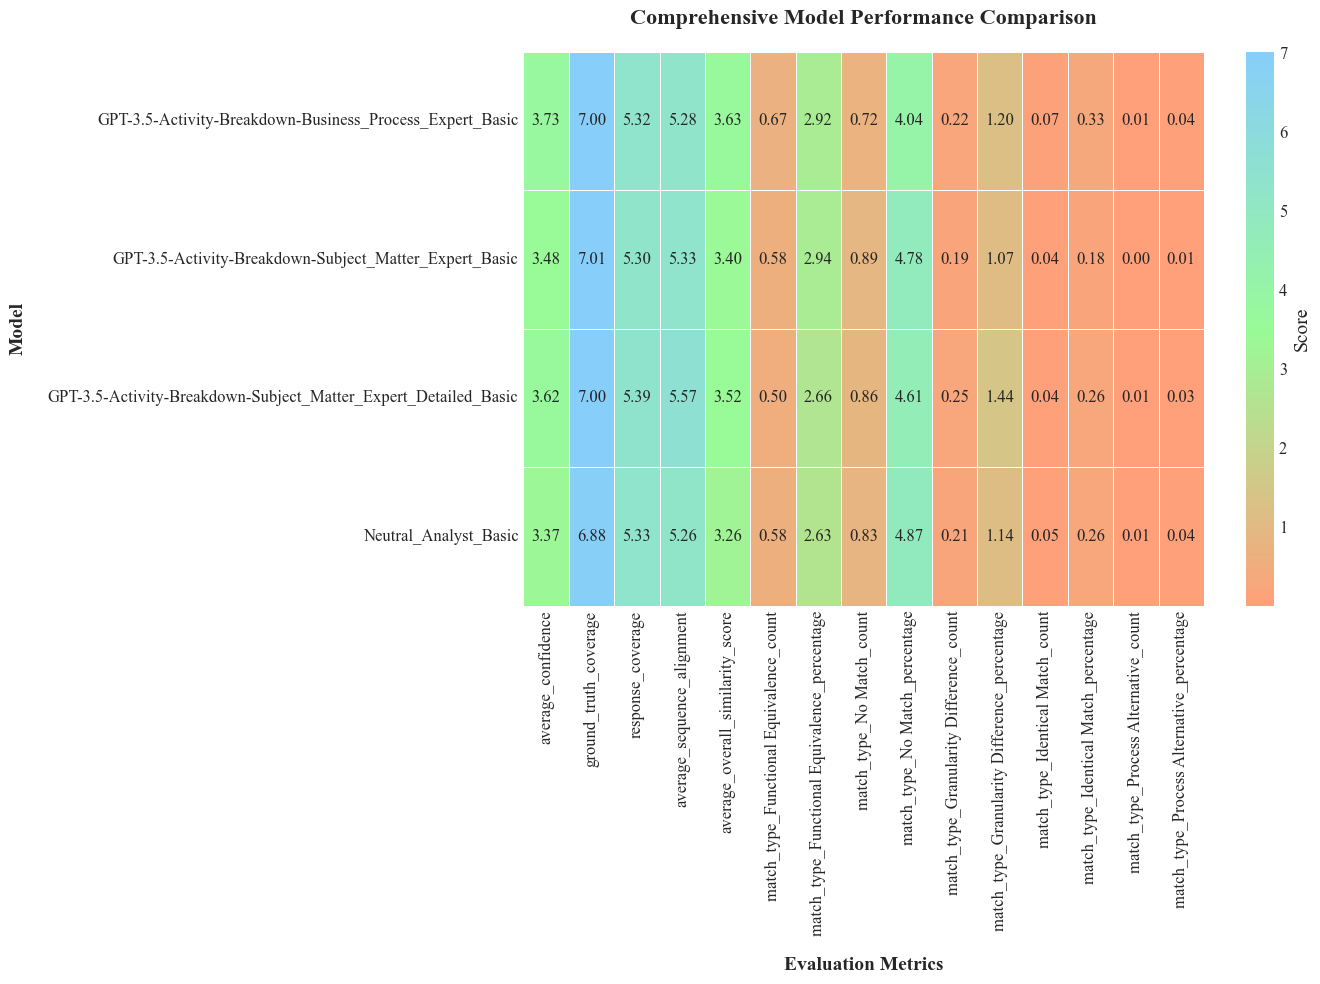

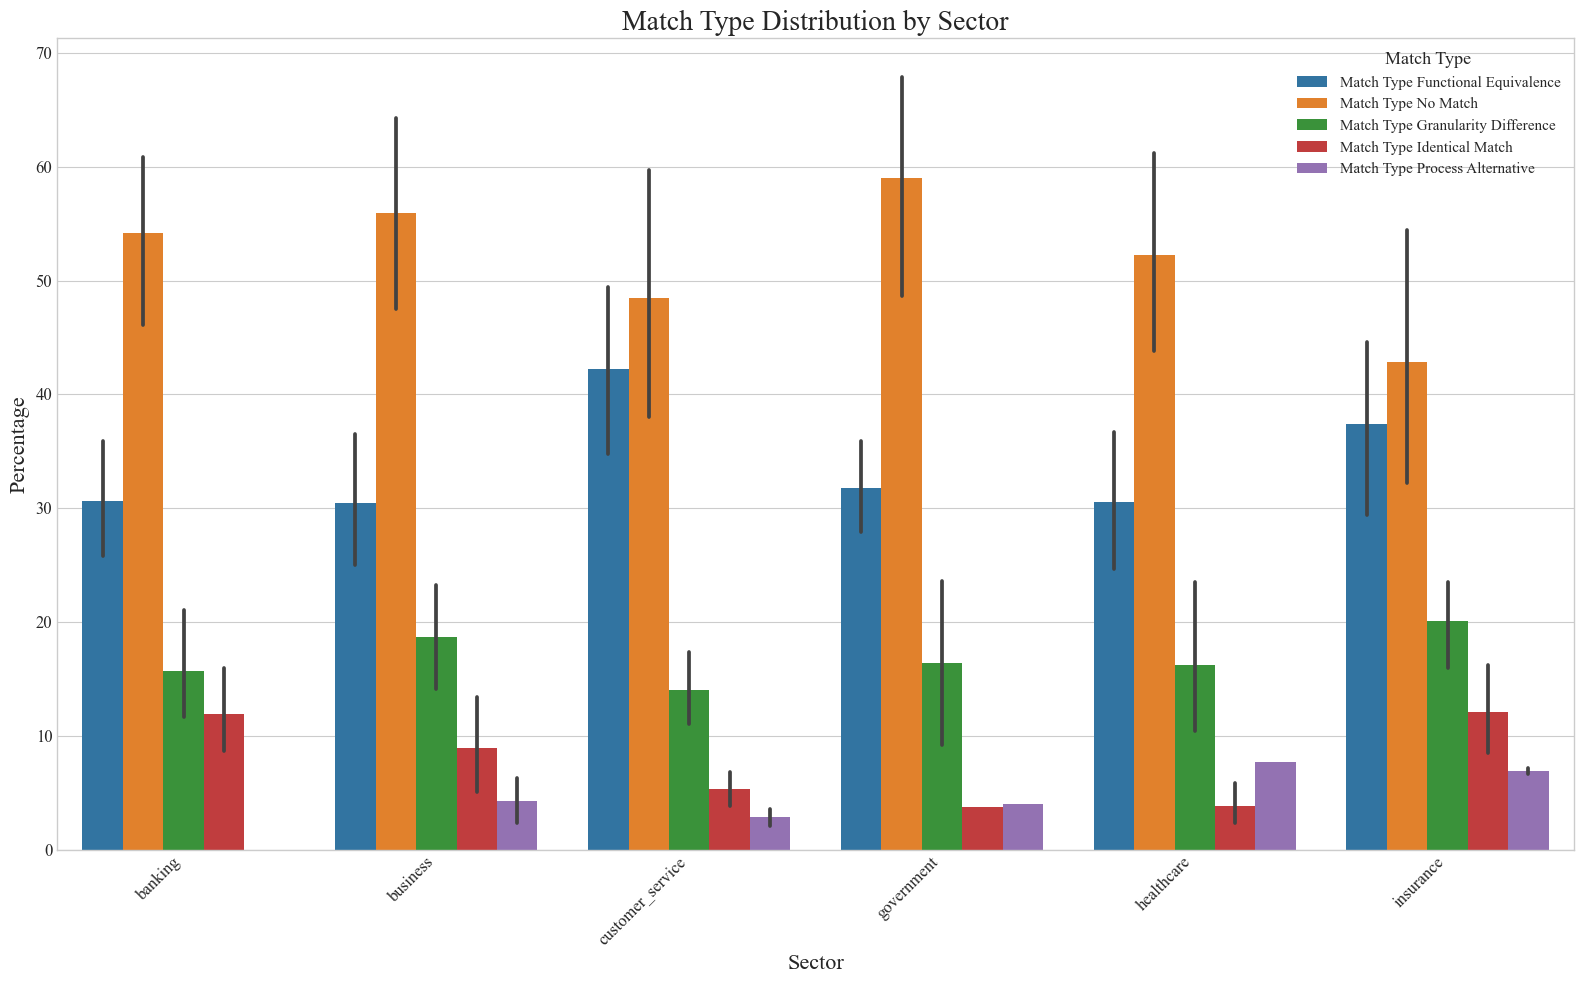

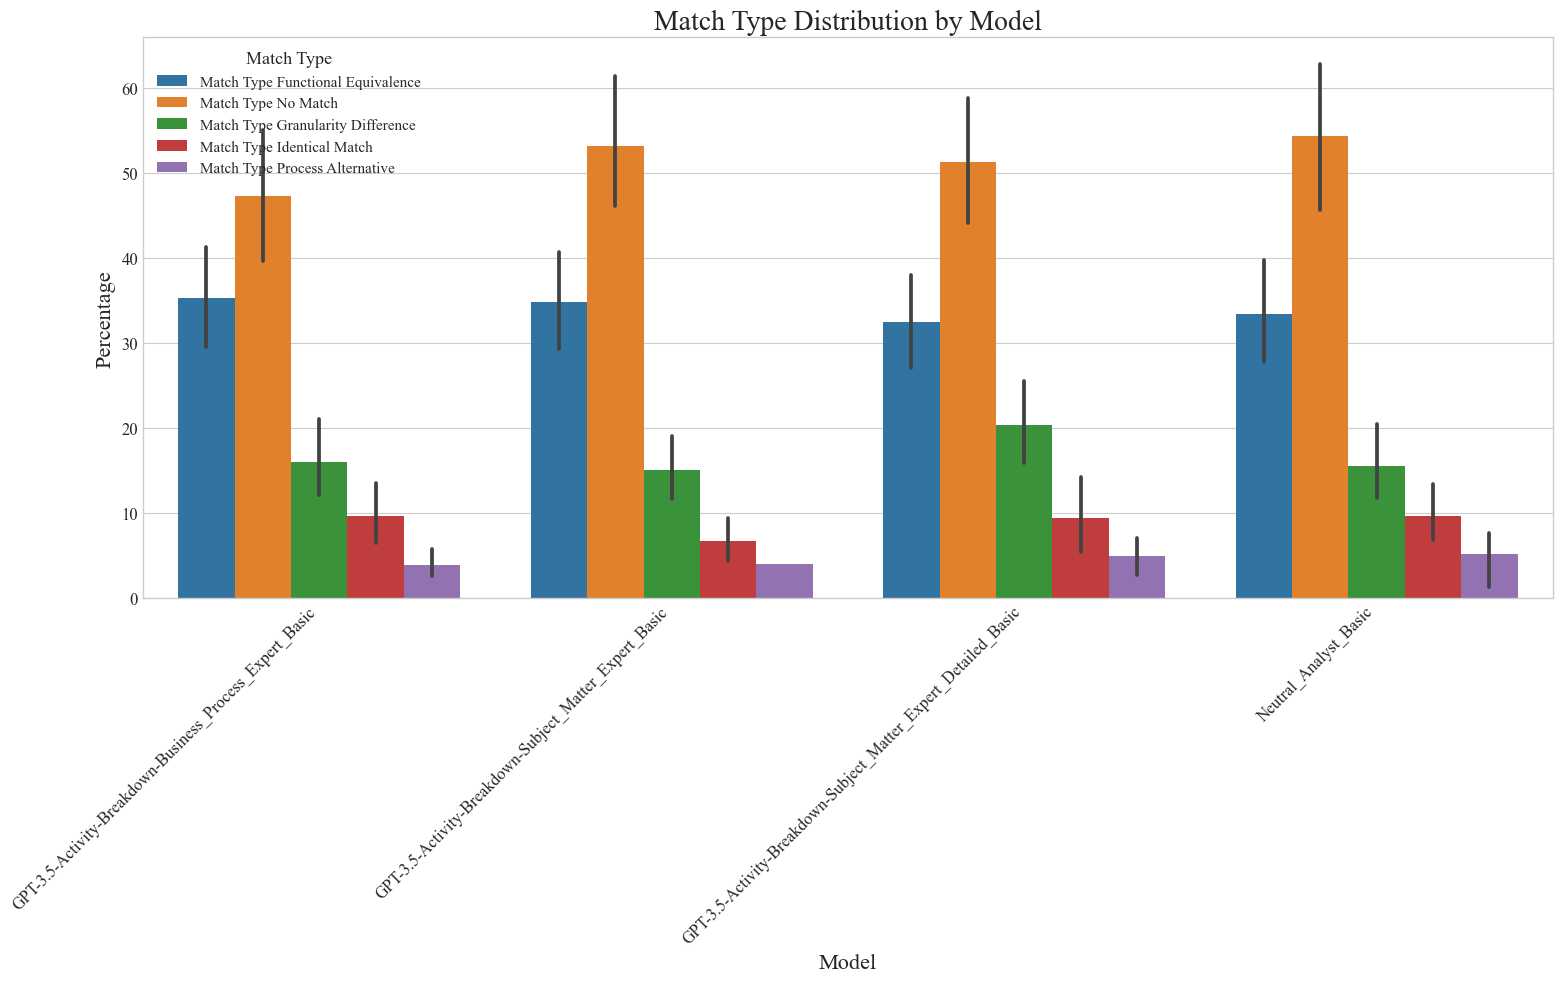

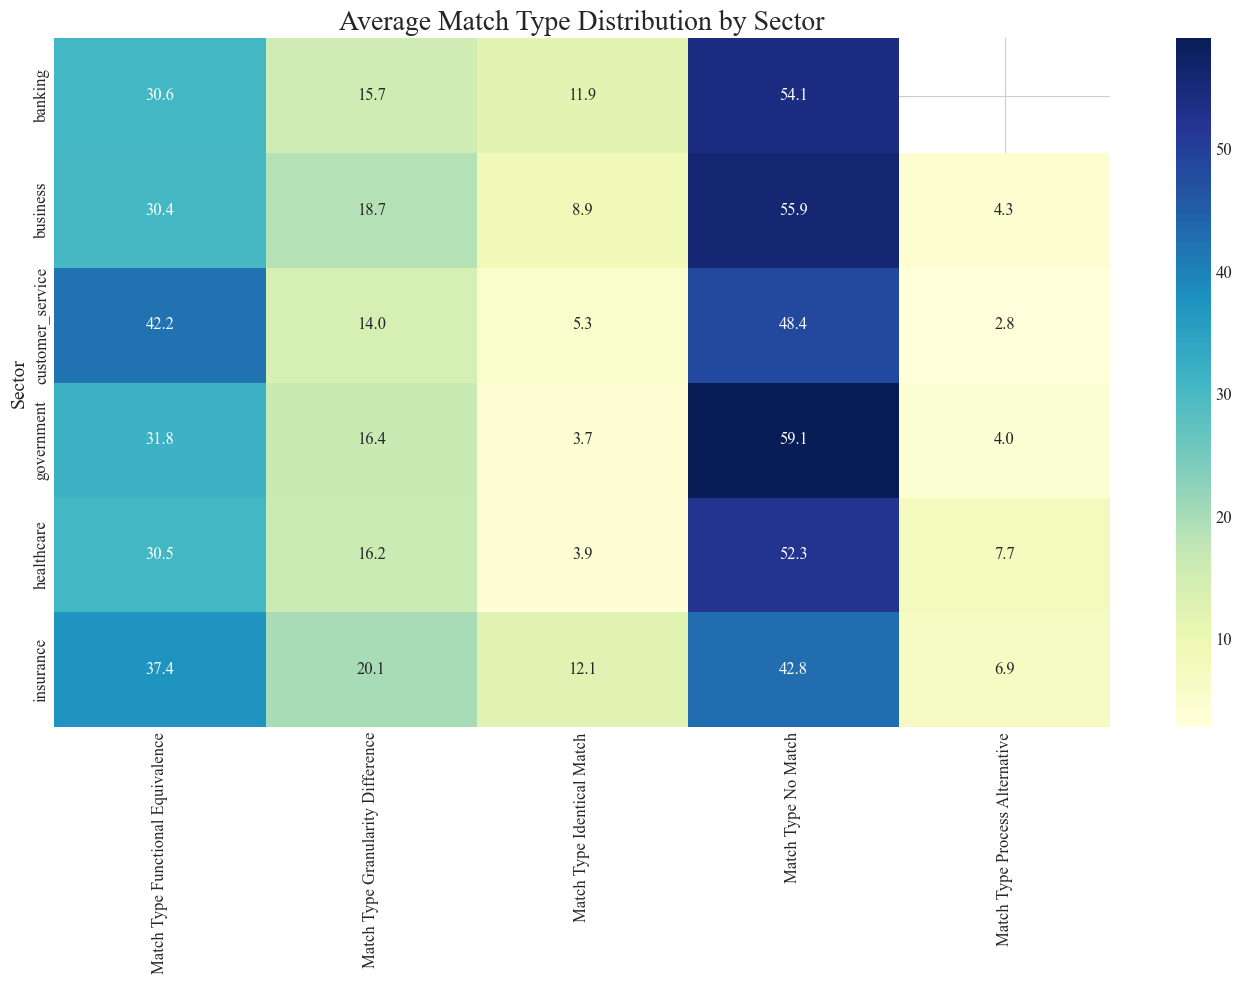

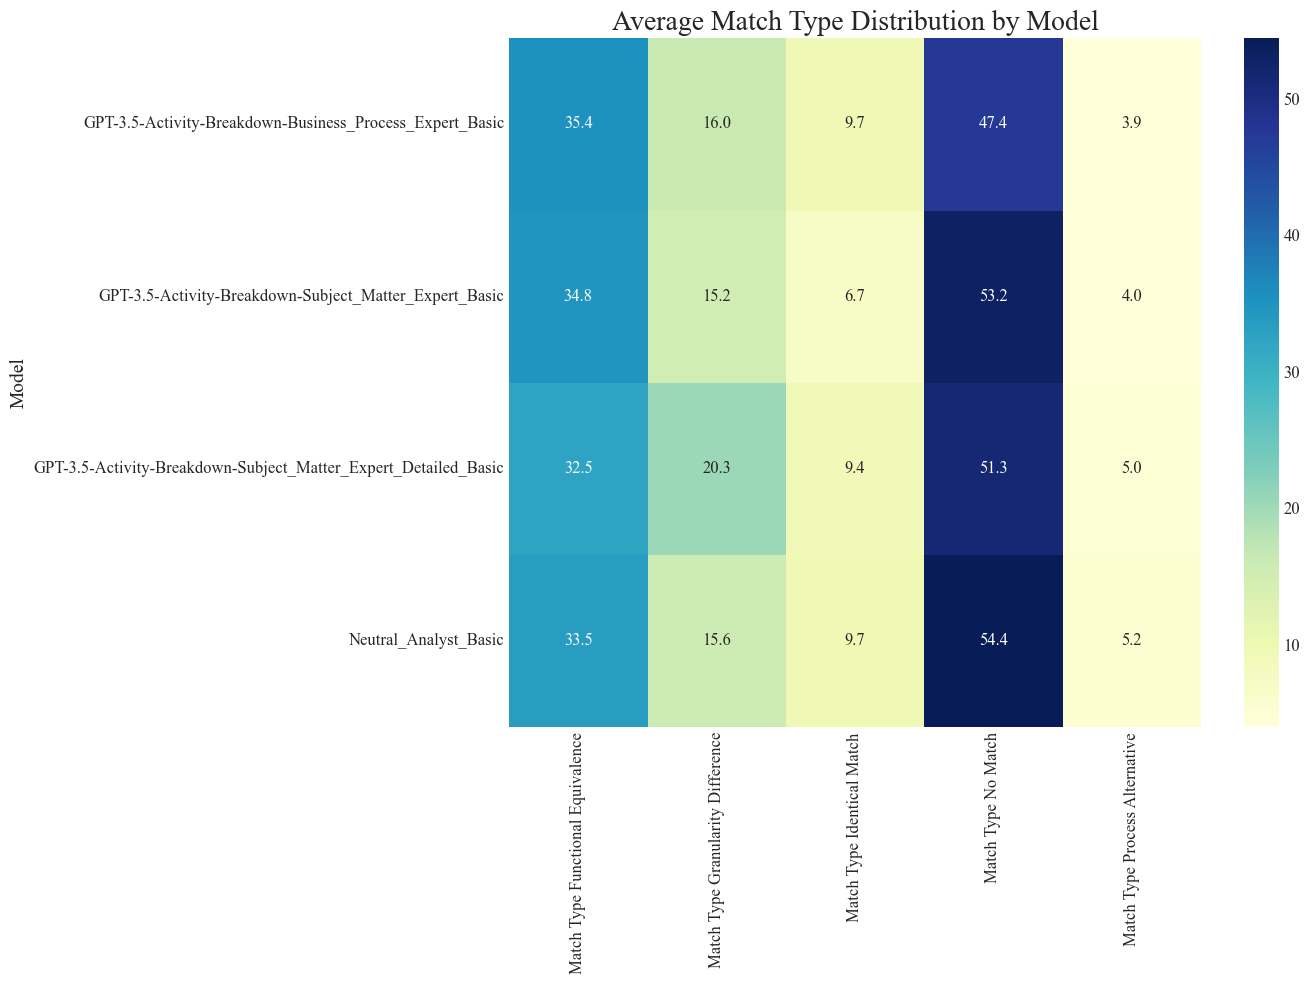

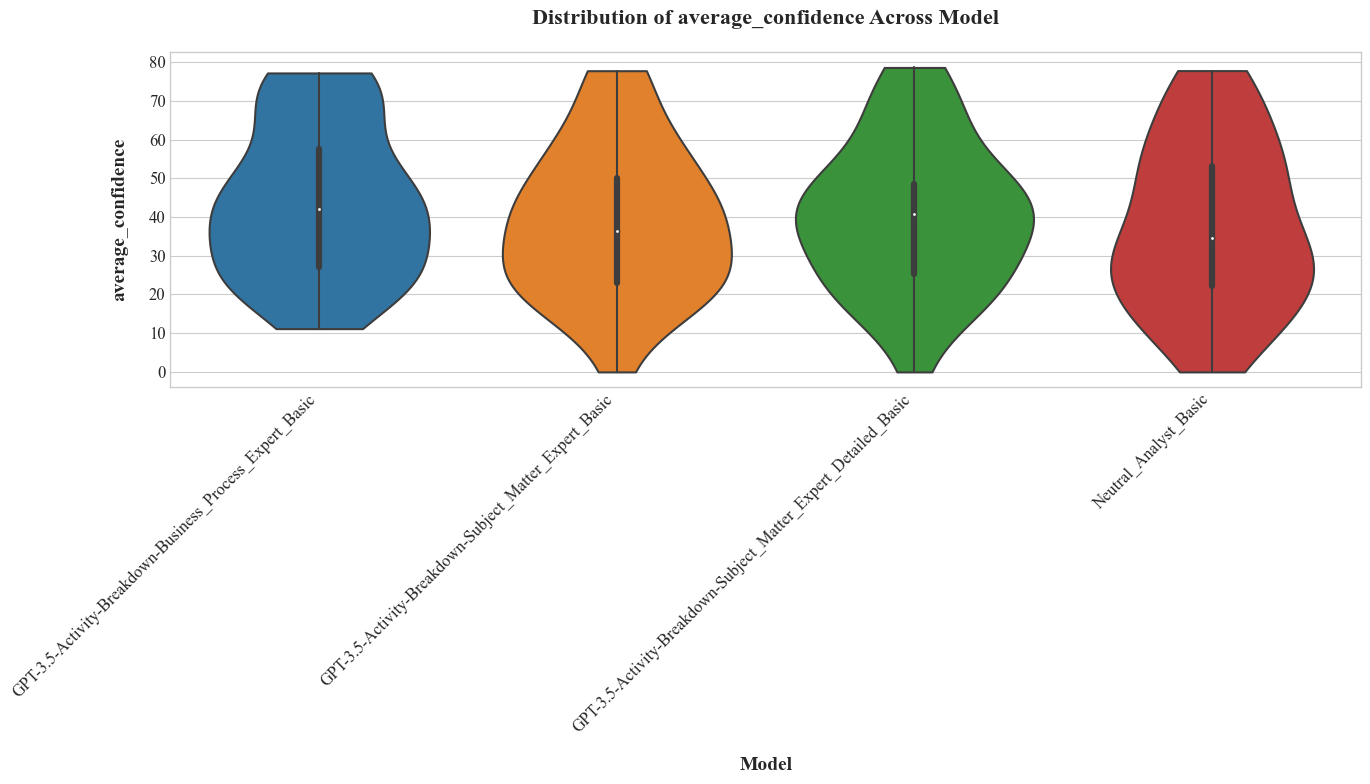

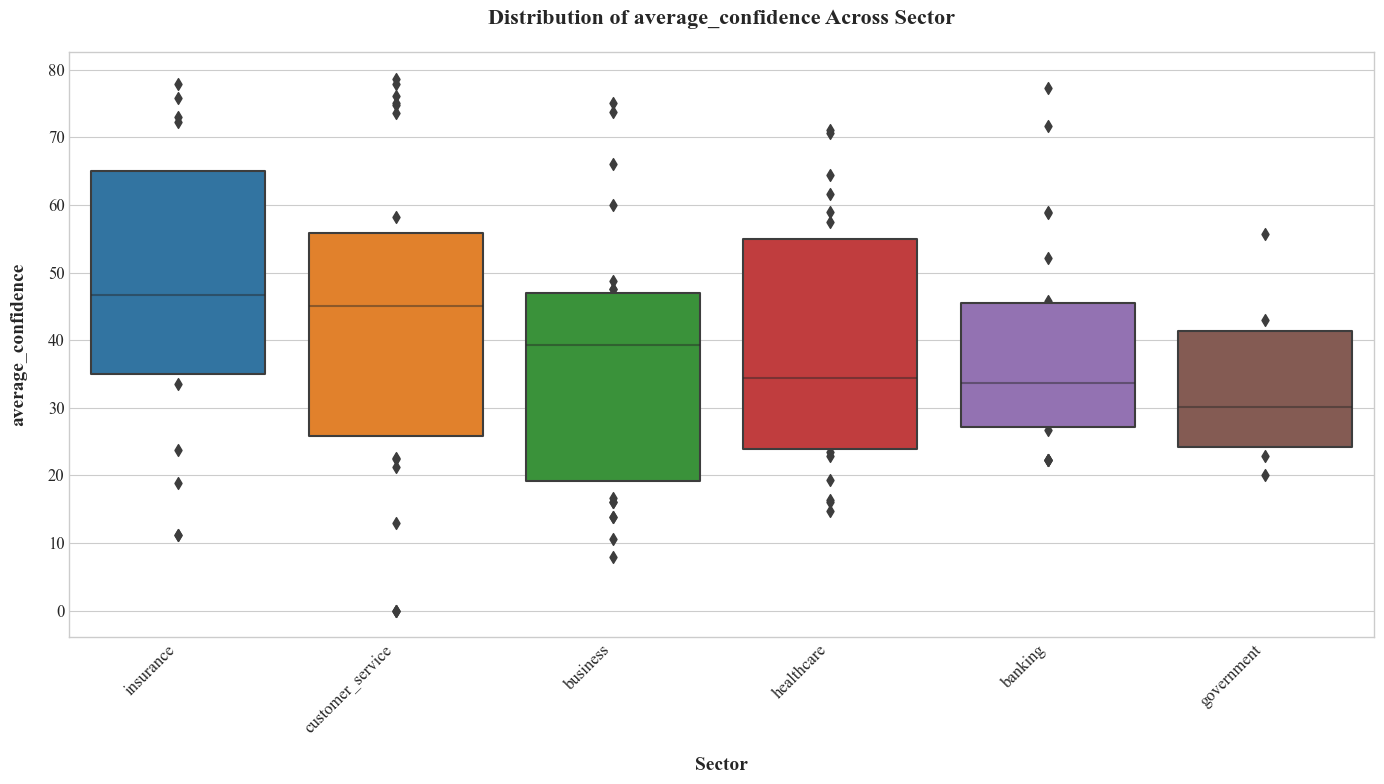

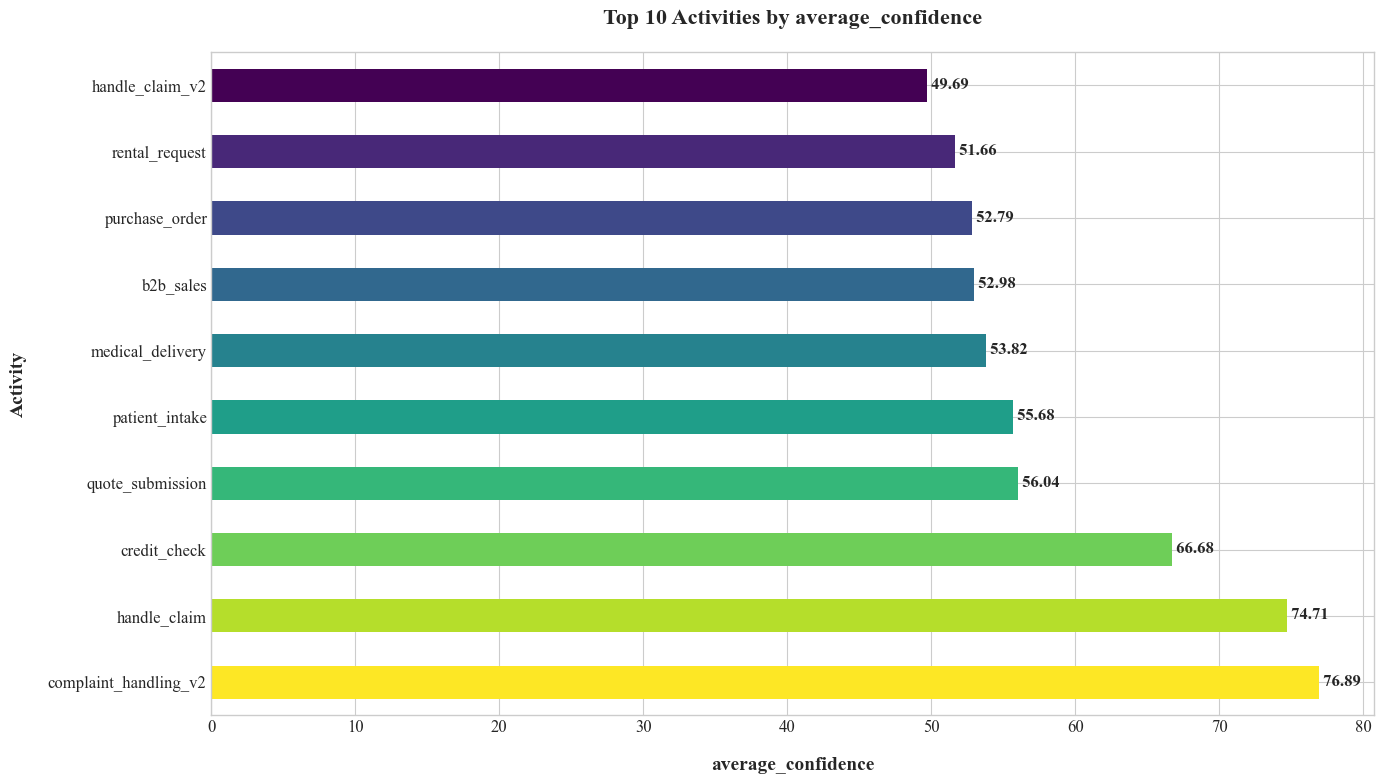

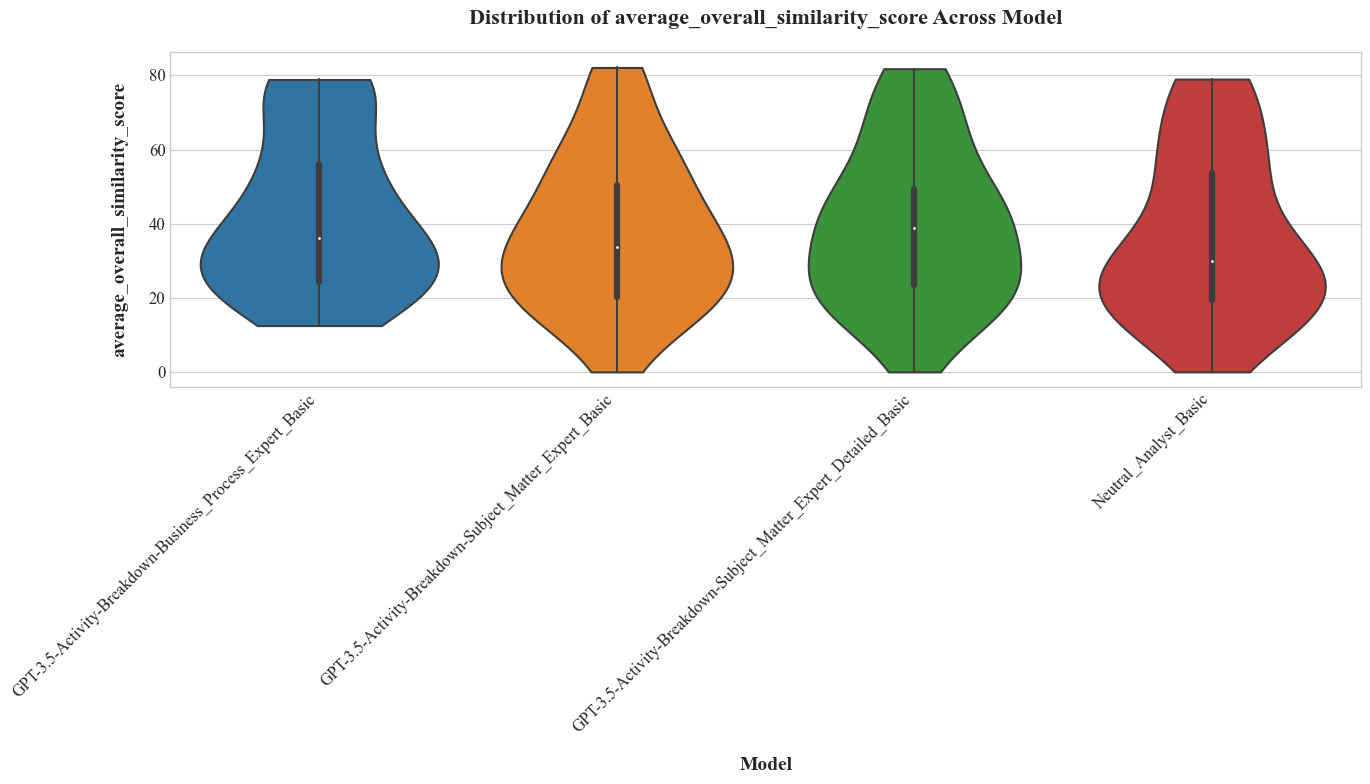

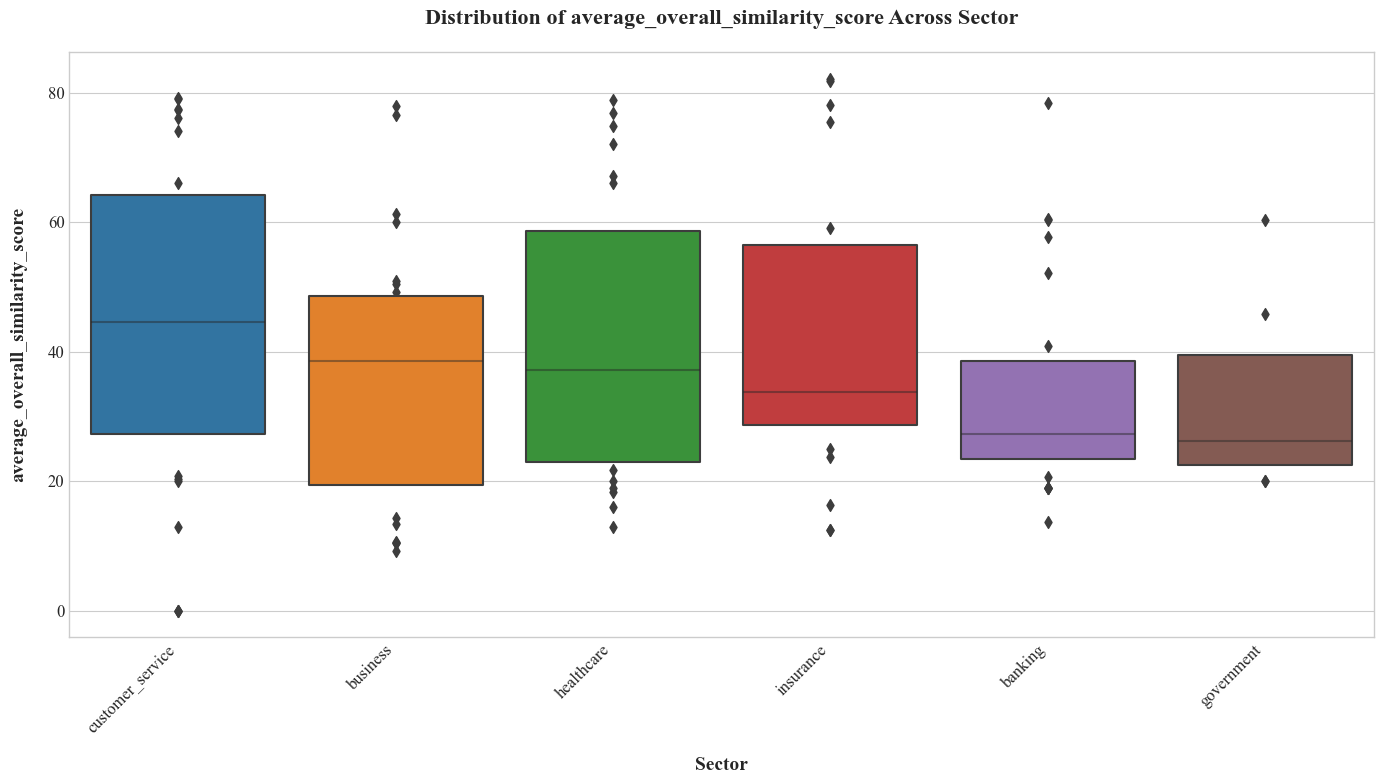

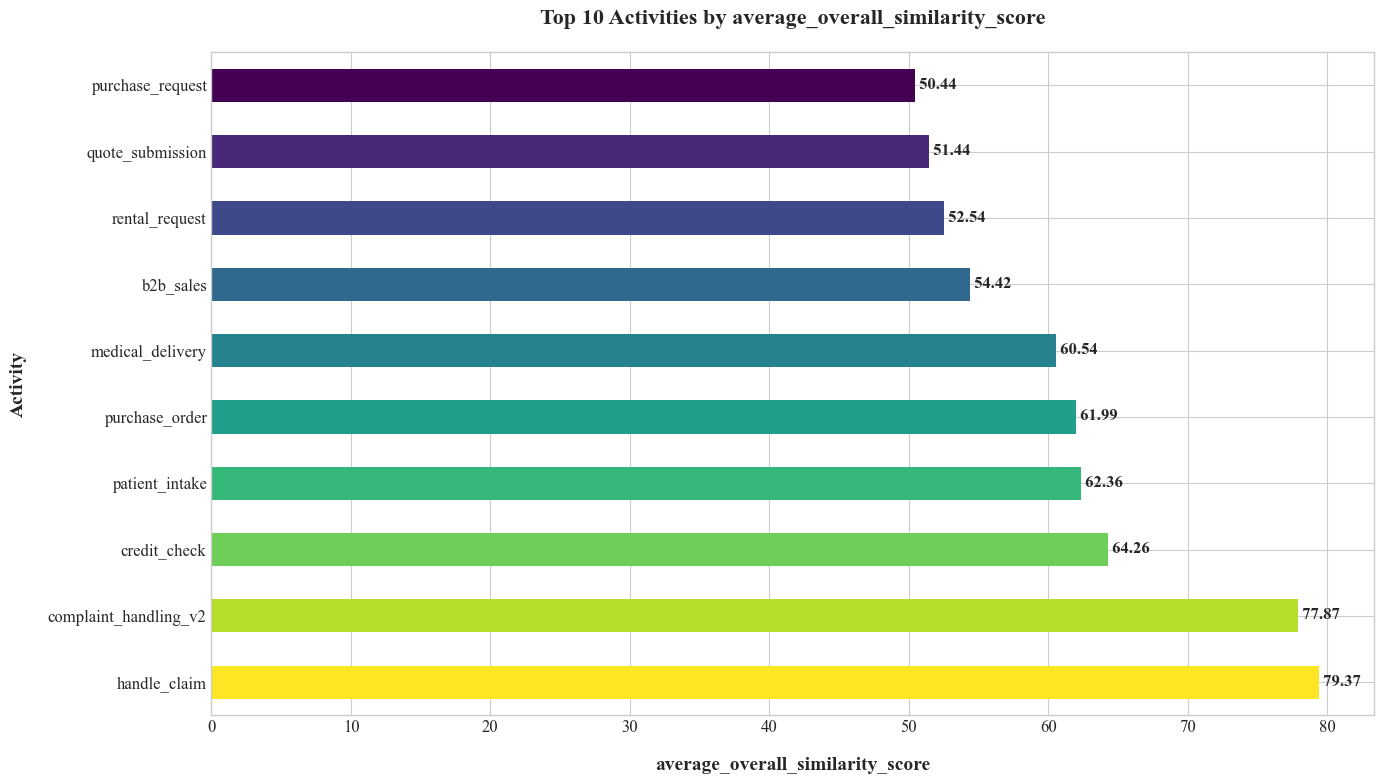

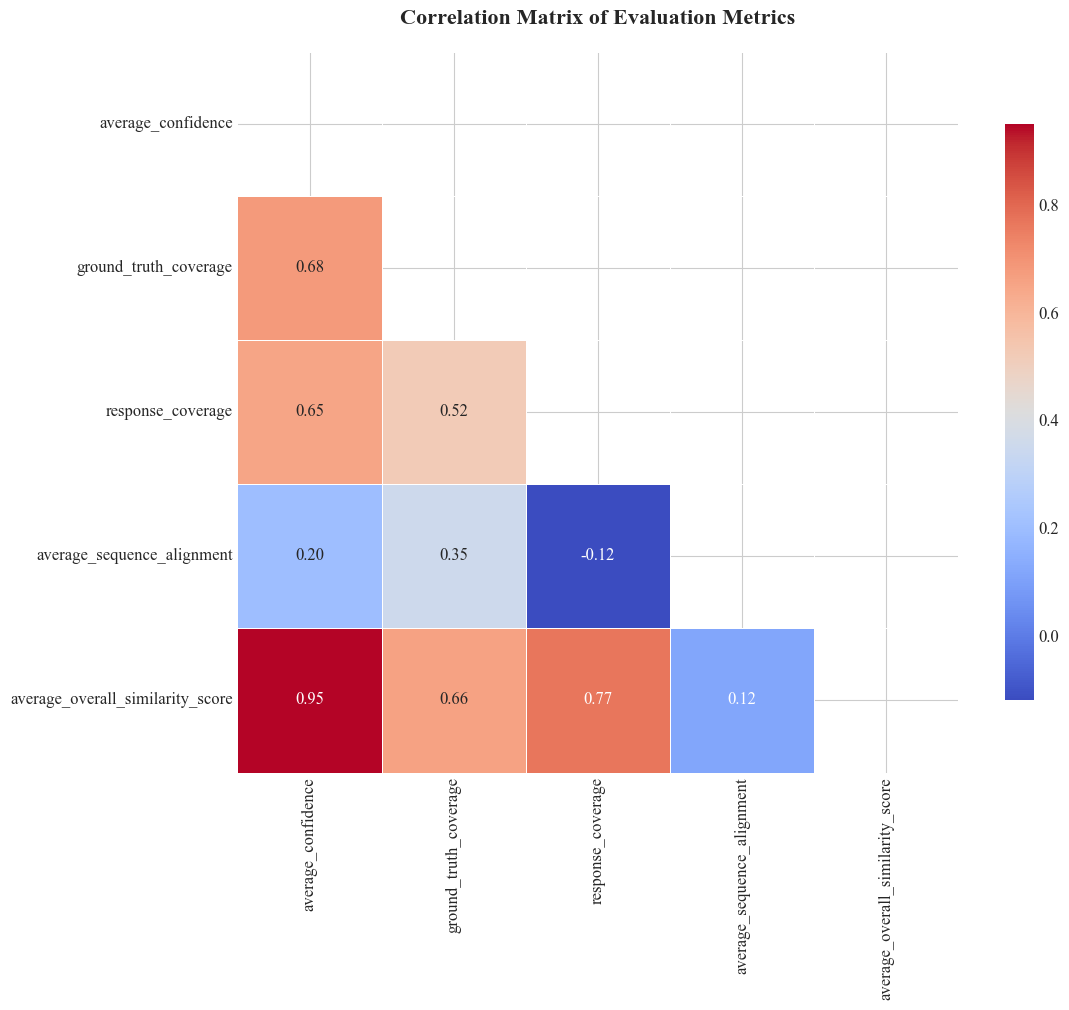

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 20

ROOT_DIR = r"C:\Projects\Research\SWEEP\SWEEP"

def load_data():
    base_path = os.path.join(ROOT_DIR, 'test/evaluation/activity_breakdown')
    activity_df = pd.read_csv(os.path.join(base_path, 'activity_comparison_report.csv'))
    model_df = pd.read_csv(os.path.join(base_path, 'overall_model_comparison_report.csv'))
    return activity_df, model_df

def custom_cmap():
    return LinearSegmentedColormap.from_list("", ["#FFA07A", "#98FB98", "#87CEFA"])

def plot_overall_model_comparison(model_df):
    plt.figure(figsize=(14, 10))
    sns.heatmap(model_df.set_index('Model'), annot=True, cmap=custom_cmap(), fmt='.2f',
                linewidths=0.5, cbar_kws={'label': 'Score'})
    plt.title('Comprehensive Model Performance Comparison', fontweight='bold', pad=20)
    plt.xlabel('Evaluation Metrics', fontweight='bold', labelpad=15)
    plt.ylabel('Model', fontweight='bold', labelpad=15)
    plt.tight_layout()
    plt.show()

def plot_match_type_distribution(df, x_column, title):
    match_type_columns = [col for col in df.columns if col.startswith('Match Type ')]
    
    if not match_type_columns:
        print(f"No 'Match Type' columns found for {title}. Skipping this plot.")
        return
    
    plot_data = df.melt(id_vars=[x_column], value_vars=match_type_columns, 
                        var_name='Match Type', value_name='Percentage')
    
    # Remove rows with NaN values
    plot_data = plot_data.dropna()
    
    if plot_data.empty:
        print(f"No valid data to plot for {title}. Skipping this plot.")
        return
    
    plt.figure(figsize=(16, 10))
    sns.barplot(x=x_column, y='Percentage', hue='Match Type', data=plot_data)
    plt.title(title, fontsize=20)
    plt.xlabel(x_column, fontsize=16)
    plt.ylabel('Percentage', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Match Type', title_fontsize='13', fontsize='11')
    plt.tight_layout()
    plt.show()

def plot_heatmap_matchtype(df, index_column, title):
    match_type_columns = [col for col in df.columns if col.startswith('Match Type ')]
    
    if not match_type_columns:
        print(f"No 'Match Type' columns found for {title}. Skipping this plot.")
        return
    
    pivot_df = df.pivot_table(values=match_type_columns, index=index_column, aggfunc='mean')
    
    if pivot_df.empty:
        print(f"No valid data to plot for {title}. Skipping this plot.")
        return
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='YlGnBu')
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

def plot_metric_by_category(activity_df, metric, category):
    plt.figure(figsize=(14, 8))
    if category == 'Model':
        sns.violinplot(x=category, y=metric, data=activity_df, cut=0, inner="box")
    else:
        category_order = activity_df.groupby(category)[metric].median().sort_values(ascending=False).index
        sns.boxenplot(x=category, y=metric, data=activity_df, order=category_order)
    plt.title(f'Distribution of {metric} Across {category}', fontweight='bold', pad=20)
    plt.xlabel(category, fontweight='bold', labelpad=15)
    plt.ylabel(metric, fontweight='bold', labelpad=15)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_top_activities(activity_df, metric, top_n=10):
    top_activities = activity_df.groupby('Activity')[metric].mean().nlargest(top_n).sort_values(ascending=True)
    plt.figure(figsize=(14, 8))
    ax = top_activities.plot(kind='barh', color=plt.cm.viridis(np.linspace(0, 1, top_n)))
    plt.title(f'Top {top_n} Activities by {metric}', fontweight='bold', pad=20)
    plt.xlabel(metric, fontweight='bold', labelpad=15)
    plt.ylabel('Activity', fontweight='bold', labelpad=15)
    plt.gca().invert_yaxis()
    
    for i, v in enumerate(top_activities):
        ax.text(v, i, f' {v:.2f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(activity_df):
    metrics = ['average_confidence', 'ground_truth_coverage', 'response_coverage', 
               'average_sequence_alignment', 'average_overall_similarity_score']
    corr_matrix = activity_df[metrics].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Evaluation Metrics', fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def generate_visual_reports():
    activity_df, model_df = load_data()
    
    # Print column names to check if 'Match Type' columns exist
    print("Columns in activity_df:")
    print(activity_df.columns)
    print("\nColumns in model_df:")
    print(model_df.columns)
    
    plot_overall_model_comparison(model_df)
    
    plot_match_type_distribution(activity_df, 'Sector', 'Match Type Distribution by Sector')
    plot_match_type_distribution(activity_df, 'Model', 'Match Type Distribution by Model')
    plot_heatmap_matchtype(activity_df, 'Sector', 'Average Match Type Distribution by Sector')
    plot_heatmap_matchtype(activity_df, 'Model', 'Average Match Type Distribution by Model')
    
    metrics = ['average_confidence','average_overall_similarity_score']
    
    for metric in metrics:
        if metric in activity_df.columns:
            plot_metric_by_category(activity_df, metric, 'Model')
            plot_metric_by_category(activity_df, metric, 'Sector')
            plot_top_activities(activity_df, metric)
        else:
            print(f"Metric '{metric}' not found in the data. Skipping related plots.")
    
    plot_correlation_matrix(activity_df)

if __name__ == "__main__":
    generate_visual_reports()